2022-06-01 11:53:26.781417: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-06-01 11:53:26.781463: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: spk
2022-06-01 11:53:26.781471: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: spk
2022-06-01 11:53:26.781600: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-06-01 11:53:26.781626: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-06-01 11:53:26.781633: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.103.1 does not match DSO version 470.129.6 -- cannot find working devices in this configuration
2022-06-01 11:53:26.781901: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binar

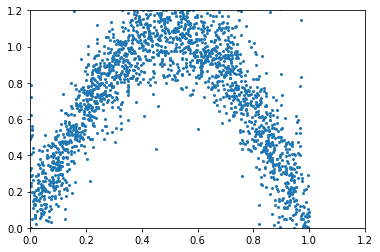

tf.Tensor([[2.5554432e-04 9.9974447e-01]], shape=(1, 2), dtype=float32)
Class :  tf.Tensor([1], shape=(1,), dtype=int64)
Press enter to continue...q


'q'

In [1]:
import os
import sys
from shutil import copyfile
import json
import numpy as np
from sklearn.model_selection import train_test_split 
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

# add parent directory of project to system path, to access all the packages in project, sys.path.append appends are not permanent
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('train.py')))))))

from src.data.toy_models.ParabolicModel import ParabolicModel
from src.data.toy_models.SineModel import SineModel
from src.data.toy_models.TrueModel import TrueModel

from src.model.VAEGAN.Encoder import Encoder 
from src.model.VAEGAN.Generator import Generator
from src.model.VAEGAN.Discriminator import Discriminator
from src.model.VAEGAN.UnsupervisedDiscriminator import UnsupervisedDiscriminator
from src.model.VAEGAN.SupervisedDiscriminator import SupervisedDiscriminator
from src.model.VAEGAN.VAEGAN import VAEGAN
from src.model.VAEGAN.toy.GANMonitor import GANMonitor

readlines = ""
with open('Params.json') as file:
    readlines = file.read() 

Params = json.loads(readlines) 
latent_dim = Params['latent_dim'] 
epochs = Params['epochs']
patience = Params['patience']
lr_gen = Params['lr_gen']
beta_1_gen = Params['beta_1_gen']
lr_disc = Params['lr_disc']
beta_1_disc= Params['beta_1_disc']
batch_size = Params['batch_size']
input_dim = Params['input_dim']
output_dim = Params['output_dim']
n_classes = Params['n_classes']
train_size = Params['train_size']
buffer_size = train_size 
outdir = Params['outdir'] 

#def generate_real_samples(train_size, z, input_dim):
#    half_train_size = int(train_size/2) 
#    parabolicModelObj = ParabolicModel()
#    x1 = np.zeros([half_train_size, input_dim], dtype='float32')
#    for i in range(half_train_size):
#        x1[i] = parabolicModelObj.sample(z)
#    y1 = np.zeros(half_train_size)
#    sineModelObj = SineModel()
#    x2 = np.zeros([half_train_size, input_dim], dtype='float32')
#    for i in range(half_train_size):
#        x2[i] = sineModelObj.sample(z)
#    y2 = np.ones(half_train_size)
#    x_real = np.concatenate([x1, x2])
#    y_real = np.concatenate([y1, y2])
#    return x_real, y_real
#

z = np.genfromtxt('../../../data/toy_models/z.csv')
z_obs = np.genfromtxt('../../../data/toy_models/z_obs.csv')

trueModelObj = TrueModel()
x_obs = trueModelObj.sample(z_obs)

#x_real, y_real = generate_real_samples(train_size, z, output_dim) 
#prng = np.random.RandomState(123)
#idx = prng.randint(0, output_dim, input_dim)
#x_real_580 = x_real[:,idx]
#y_real = y_real[:, np.newaxis]
#
## split into test, validation, and training sets
#x_train_580, x_test_580, x_train, x_test, y_train, y_test = train_test_split(x_real_580, x_real, y_real, test_size=0.2)
#x_train_580, x_val_580, x_train, x_val, y_train, y_val = train_test_split(x_train_580, x_train, y_train, test_size=0.2)
#
#train_dataset = ( 
#    tf.data.Dataset
#        .from_tensor_slices((x_train_580, x_train, y_train))
#        .shuffle(buffer_size, reshuffle_each_iteration=True)
#        .batch(batch_size)
#        .prefetch(tf.data.AUTOTUNE)
#)
#
#val_dataset = (
#    tf.data.Dataset
#        .from_tensor_slices((x_val_580, x_val, y_val))
#        .shuffle(buffer_size)
#        .batch(batch_size)
#)
#
#test_dataset = (
#    tf.data.Dataset
#        .from_tensor_slices((x_test_580, x_test, y_test))
#        .shuffle(buffer_size)
#        .batch(batch_size)
#)

encoder = Encoder(input_dim, latent_dim)
generator = Generator(latent_dim)
discriminator = Discriminator(output_dim, n_classes)
sup_discriminator = SupervisedDiscriminator(discriminator)
unsup_discriminator = UnsupervisedDiscriminator(discriminator)

vaegan = VAEGAN(latent_dim, encoder, generator, discriminator, sup_discriminator, unsup_discriminator, z)
vaegan.compile(
    tf.keras.optimizers.Adam(learning_rate=lr_gen, beta_1=beta_1_gen),
    tf.keras.optimizers.Adam(learning_rate=lr_disc, beta_1=beta_1_disc), 
    tf.keras.optimizers.Adam(learning_rate=lr_disc, beta_1=beta_1_disc),
    tf.keras.optimizers.Adam(learning_rate=lr_gen, beta_1=beta_1_gen),
    tf.keras.losses.BinaryCrossentropy(from_logits=False),
    tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
)

vaegan_checkpoint_path = os.path.join(outdir,"ckpt/vaegan.ckpt")

# load the best model
vaegan.load_weights(vaegan_checkpoint_path)

x = vaegan.out_with_enc(x_obs.reshape(-1,580))

input('Press enter to continue...')
